In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [19]:
# sample meta-data
sample_info = pd.read_csv('../Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual volume percentages
data = np.loadtxt('../../uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act_vol
    actual_stdev[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       #'Polystyrene-D8':6.407,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426}


In [20]:
data_dir = '../Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Splitting up the fits

In [21]:
true_keys = []

true_reads = pd.read_csv('../Fit_Truths.csv')
true_reads = true_reads.to_numpy()
mask = true_reads[:,1].astype(bool)

sphere_keys = true_reads[mask,0]

split_num = int(len(sphere_keys)/3)

# Sage, uncomment the next line for the samples you will run
#run_keys = list(sphere_keys[:split_num])

# Lorenzo, uncomment the next line for the samples you will run
#run_keys = list(sphere_keys[split_num:2*split_num])

# Caitlyn, uncomment the next line for the samples you will run
# run_keys = list(sphere_keys[split_num*2:])

Loading polystyrene fit information.

In [22]:
background_files = [file for file in os.listdir('../PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [23]:
power_law_fit_info = pd.read_json('../PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [24]:
guinier_porod_fit = pd.read_json('../PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [25]:
ps_s

2.527970343604298

In [26]:
ps_porod_exp

3.495374117152284

We will set limits for the polystyrene portion of the fit based on average values from the guinier_porod polystyrene fits. The scale will also be adjusted based on 1-x where x is the volume fraction of conjugated polymer in each specific sample as determined by UV-Vis. We are assuming that volume fraction is equivalent to weight fraction in this case; estimates show that error is minimal.

In [27]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [28]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


In [29]:
avg_rg

180.08039395244816

In [30]:
avg_scale

0.00021282869261837612

Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [31]:
porod_files = [file for file in os.listdir('../Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

In [32]:
kernel = load_model("guinier_porod+sphere")
model = Model(kernel)
model.parameters()

{'scale': Parameter(scale),
 'background': Parameter(background),
 'A_scale': Parameter(A_scale),
 'A_rg': Parameter(A_rg),
 'A_s': Parameter(A_s),
 'A_porod_exp': Parameter(A_porod_exp),
 'B_scale': Parameter(B_scale),
 'B_sld': Parameter(B_sld),
 'B_sld_solvent': Parameter(B_sld_solvent),
 'B_radius': Parameter(B_radius),
 'B_radius_pd': Parameter(B_radius_pd),
 'B_radius_pd_n': Parameter(B_radius_pd_n),
 'B_radius_pd_nsigma': Parameter(B_radius_pd_nsigma),
 'up_frac_i': Parameter(up_frac_i),
 'up_frac_f': Parameter(up_frac_f),
 'up_angle': Parameter(up_angle),
 'B_sld_M0': Parameter(B_sld_M0),
 'B_sld_mtheta': Parameter(B_sld_mtheta),
 'B_sld_mphi': Parameter(B_sld_mphi),
 'B_sld_solvent_M0': Parameter(B_sld_solvent_M0),
 'B_sld_solvent_mtheta': Parameter(B_sld_solvent_mtheta),
 'B_sld_solvent_mphi': Parameter(B_sld_solvent_mphi)}

# steps: 50000, # draws: 1000000
step 1 cost 126.4153(99)
                       101 sphere radius |.........    9999.86 in (0,150000)
                        101 sphere scale ....|..... 0.000466837 in (0,inf), norm(0.000466837,3.74936e-05)
step 13 cost 126.0820(99)
step 25 cost 126.0260(99)
step 37 cost 75.0993(99)
step 50 cost 25.4015(99)
step 63 cost 25.3649(99)
step 76 cost 25.3649(99)
step 90 cost 25.3649(99)
step 105 cost 25.3649(99)
step 116 cost 25.2959(99)
step 129 cost 25.2920(99)
step 141 cost 25.2901(99)
step 153 cost 25.2861(99)
step 167 cost 25.2855(99)
step 180 cost 25.2855(99)
step 195 cost 25.2855(99)
step 209 cost 25.2854(99)
step 222 cost 25.2854(99)
step 233 cost 25.2854(99)
step 247 cost 25.2854(99)
step 261 cost 25.2853(99)
step 275 cost 25.2853(99)
step 288 cost 25.2853(99)
step 299 cost 25.2853(99)
step 312 cost 25.2853(99)
step 325 cost 25.2853(99)
step 338 cost 25.2853(99)
step 351 cost 25.2853(99)
step 364 cost 25.2853(99)
                       101 sphere ra

step 3134 cost 25.2853(99)
step 3145 cost 25.2853(99)
step 3159 cost 25.2853(99)
step 3172 cost 25.2853(99)
step 3185 cost 25.2853(99)
step 3198 cost 25.2853(99)
step 3211 cost 25.2853(99)
step 3225 cost 25.2853(99)
step 3239 cost 25.2853(99)
step 3252 cost 25.2853(99)
step 3266 cost 25.2853(99)
step 3280 cost 25.2853(99)
step 3294 cost 25.2853(99)
step 3308 cost 25.2853(99)
step 3322 cost 25.2853(99)
                       101 sphere radius |.........     329.05 in (0,150000)
                        101 sphere scale .........| 0.000693736 in (0,inf), norm(0.000466837,3.74936e-05)
step 3336 cost 25.2853(99)
step 3350 cost 25.2853(99)
step 3363 cost 25.2853(99)
step 3374 cost 25.2853(99)
step 3386 cost 25.2853(99)
step 3399 cost 25.2853(99)
step 3412 cost 25.2853(99)
step 3426 cost 25.2853(99)
step 3440 cost 25.2853(99)
step 3452 cost 25.2853(99)
step 3466 cost 25.2853(99)
step 3478 cost 25.2853(99)
step 3491 cost 25.2853(99)
step 3503 cost 25.2853(99)
step 3515 cost 25.2853(99)
step 35

step 6299 cost 25.2853(99)
step 6311 cost 25.2853(99)
step 6322 cost 25.2853(99)
step 6333 cost 25.2853(99)
step 6346 cost 25.2853(99)
step 6359 cost 25.2853(99)
step 6372 cost 25.2853(99)
step 6384 cost 25.2853(99)
step 6397 cost 25.2853(99)
step 6410 cost 25.2853(99)
step 6423 cost 25.2853(99)
step 6436 cost 25.2853(99)
step 6447 cost 25.2853(99)
step 6458 cost 25.2853(99)
step 6470 cost 25.2853(99)
step 6482 cost 25.2853(99)
step 6495 cost 25.2853(99)
step 6509 cost 25.2853(99)
step 6523 cost 25.2853(99)
step 6536 cost 25.2853(99)
step 6549 cost 25.2853(99)
step 6562 cost 25.2853(99)
step 6575 cost 25.2853(99)
step 6589 cost 25.2853(99)
step 6603 cost 25.2853(99)
step 6616 cost 25.2853(99)
step 6629 cost 25.2853(99)
step 6643 cost 25.2853(99)
step 6656 cost 25.2853(99)
                       101 sphere radius |.........     329.05 in (0,150000)
                        101 sphere scale .........| 0.000693736 in (0,inf), norm(0.000466837,3.74936e-05)
step 6669 cost 25.2853(99)
step 66

step 9692 cost 25.2853(99)
step 9705 cost 25.2853(99)
step 9719 cost 25.2853(99)
step 9733 cost 25.2853(99)
step 9746 cost 25.2853(99)
step 9760 cost 25.2853(99)
step 9774 cost 25.2853(99)
step 9788 cost 25.2853(99)
step 9802 cost 25.2853(99)
step 9815 cost 25.2853(99)
step 9829 cost 25.2853(99)
                       101 sphere radius |.........     329.05 in (0,150000)
                        101 sphere scale .........| 0.000693736 in (0,inf), norm(0.000466837,3.74936e-05)
step 9843 cost 25.2853(99)
step 9857 cost 25.2853(99)
step 9871 cost 25.2853(99)
step 9885 cost 25.2853(99)
step 9898 cost 25.2853(99)
step 9911 cost 25.2853(99)
step 9925 cost 25.2853(99)
step 9939 cost 25.2853(99)
step 9953 cost 25.2853(99)
step 9967 cost 25.2853(99)
step 9981 cost 25.2853(99)
step 9996 cost 25.2853(99)
step 10011 cost 25.2853(99)
step 10026 cost 25.2853(99)
step 10041 cost 25.2853(99)
step 10055 cost 25.2853(99)
step 10069 cost 25.2853(99)
step 10083 cost 25.2853(99)
step 10098 cost 25.2853(99)


step 13025 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 13039 cost 25.2853(99)
step 13053 cost 25.2853(99)
step 13067 cost 25.2853(99)
step 13081 cost 25.2853(99)
step 13095 cost 25.2853(99)
step 13109 cost 25.2853(99)
step 13123 cost 25.2853(99)
step 13137 cost 25.2853(99)
step 13150 cost 25.2853(99)
step 13164 cost 25.2853(99)
step 13178 cost 25.2853(99)
step 13191 cost 25.2853(99)
step 13205 cost 25.2853(99)
step 13219 cost 25.2853(99)
step 13233 cost 25.2853(99)
step 13247 cost 25.2853(99)
step 13261 cost 25.2853(99)
step 13275 cost 25.2853(99)
step 13289 cost 25.2853(99)
step 13303 cost 25.2853(99)
step 13317 cost 25.2853(99)
step 13331 cost 25.2853(99)
step 13345 cost 25.2853(99)
step 13359 cost 25.2853(99)
step 13373 cost 25.2853(99)
step 13386 cost 25.2853(99)
step 13400 cost 25.2853(99)
step 13414 cost 25.2853(99)
      

step 16164 cost 25.2853(99)
step 16177 cost 25.2853(99)
step 16189 cost 25.2853(99)
step 16201 cost 25.2853(99)
step 16212 cost 25.2853(99)
step 16225 cost 25.2853(99)
step 16238 cost 25.2853(99)
step 16247 cost 25.2853(99)
step 16258 cost 25.2853(99)
step 16271 cost 25.2853(99)
step 16284 cost 25.2853(99)
step 16298 cost 25.2853(99)
step 16313 cost 25.2853(99)
step 16327 cost 25.2853(99)
step 16341 cost 25.2853(99)
step 16352 cost 25.2853(99)
step 16364 cost 25.2853(99)
step 16377 cost 25.2853(99)
step 16389 cost 25.2853(99)
step 16401 cost 25.2853(99)
step 16415 cost 25.2853(99)
step 16427 cost 25.2853(99)
step 16438 cost 25.2853(99)
step 16449 cost 25.2853(99)
step 16462 cost 25.2853(99)
step 16474 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 16486 cost 25.2853(99)
step 16498 cost 25.2853(99)
step 16510 cost 25.2853(99)
step 1

step 19055 cost 25.2853(99)
step 19067 cost 25.2853(99)
step 19080 cost 25.2853(99)
step 19092 cost 25.2853(99)
step 19104 cost 25.2853(99)
step 19114 cost 25.2853(99)
step 19126 cost 25.2853(99)
step 19139 cost 25.2853(99)
step 19153 cost 25.2853(99)
step 19167 cost 25.2853(99)
step 19180 cost 25.2853(99)
step 19194 cost 25.2853(99)
step 19208 cost 25.2853(99)
step 19222 cost 25.2853(99)
step 19236 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 19249 cost 25.2853(99)
step 19262 cost 25.2853(99)
step 19276 cost 25.2853(99)
step 19289 cost 25.2853(99)
step 19301 cost 25.2853(99)
step 19312 cost 25.2853(99)
step 19323 cost 25.2853(99)
step 19335 cost 25.2853(99)
step 19346 cost 25.2853(99)
step 19357 cost 25.2853(99)
step 19368 cost 25.2853(99)
step 19380 cost 25.2853(99)
step 19393 cost 25.2853(99)
step 19405 cost 25.2853(99)
step 1

step 22201 cost 25.2853(99)
step 22215 cost 25.2853(99)
step 22229 cost 25.2853(99)
step 22243 cost 25.2853(99)
step 22257 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 22271 cost 25.2853(99)
step 22285 cost 25.2853(99)
step 22299 cost 25.2853(99)
step 22313 cost 25.2853(99)
step 22327 cost 25.2853(99)
step 22341 cost 25.2853(99)
step 22355 cost 25.2853(99)
step 22368 cost 25.2853(99)
step 22382 cost 25.2853(99)
step 22395 cost 25.2853(99)
step 22408 cost 25.2853(99)
step 22422 cost 25.2853(99)
step 22435 cost 25.2853(99)
step 22449 cost 25.2853(99)
step 22463 cost 25.2853(99)
step 22477 cost 25.2853(99)
step 22491 cost 25.2853(99)
step 22505 cost 25.2853(99)
step 22519 cost 25.2853(99)
step 22532 cost 25.2853(99)
step 22545 cost 25.2853(99)
step 22559 cost 25.2853(99)
step 22573 cost 25.2853(99)
step 22587 cost 25.2853(99)
step 2

step 25044 cost 25.2853(99)
step 25049 cost 25.2853(99)
step 25054 cost 25.2853(99)
step 25059 cost 25.2853(99)
step 25064 cost 25.2853(99)
step 25077 cost 25.2853(99)
step 25083 cost 25.2853(99)
step 25088 cost 25.2853(99)
step 25093 cost 25.2853(99)
step 25098 cost 25.2853(99)
step 25103 cost 25.2853(99)
step 25108 cost 25.2853(99)
step 25113 cost 25.2853(99)
step 25118 cost 25.2853(99)
step 25123 cost 25.2853(99)
step 25128 cost 25.2853(99)
step 25133 cost 25.2853(99)
step 25138 cost 25.2853(99)
step 25143 cost 25.2853(99)
step 25148 cost 25.2853(99)
step 25153 cost 25.2853(99)
step 25158 cost 25.2853(99)
step 25163 cost 25.2853(99)
step 25168 cost 25.2853(99)
step 25173 cost 25.2853(99)
step 25178 cost 25.2853(99)
step 25183 cost 25.2853(99)
step 25188 cost 25.2853(99)
step 25193 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 2

step 26192 cost 25.2853(99)
step 26197 cost 25.2853(99)
step 26201 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 26205 cost 25.2853(99)
step 26209 cost 25.2853(99)
step 26214 cost 25.2853(99)
step 26219 cost 25.2853(99)
step 26223 cost 25.2853(99)
step 26225 cost 25.2853(99)
step 26228 cost 25.2853(99)
step 26233 cost 25.2853(99)
step 26238 cost 25.2853(99)
step 26243 cost 25.2853(99)
step 26248 cost 25.2853(99)
step 26253 cost 25.2853(99)
step 26258 cost 25.2853(99)
step 26262 cost 25.2853(99)
step 26267 cost 25.2853(99)
step 26271 cost 25.2853(99)
step 26276 cost 25.2853(99)
step 26280 cost 25.2853(99)
step 26283 cost 25.2853(99)
step 26287 cost 25.2853(99)
step 26292 cost 25.2853(99)
step 26297 cost 25.2853(99)
step 26301 cost 25.2853(99)
step 26305 cost 25.2853(99)
step 26309 cost 25.2853(99)
step 26314 cost 25.2853(99)
      

step 28343 cost 25.2853(99)
step 28357 cost 25.2853(99)
step 28371 cost 25.2853(99)
step 28385 cost 25.2853(99)
step 28399 cost 25.2853(99)
step 28413 cost 25.2853(99)
step 28427 cost 25.2853(99)
step 28441 cost 25.2853(99)
step 28455 cost 25.2853(99)
step 28469 cost 25.2853(99)
step 28483 cost 25.2853(99)
step 28497 cost 25.2853(99)
step 28511 cost 25.2853(99)
step 28525 cost 25.2853(99)
step 28538 cost 25.2853(99)
step 28551 cost 25.2853(99)
step 28565 cost 25.2853(99)
step 28579 cost 25.2853(99)
step 28593 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 28607 cost 25.2853(99)
step 28621 cost 25.2853(99)
step 28634 cost 25.2853(99)
step 28647 cost 25.2853(99)
step 28661 cost 25.2853(99)
step 28674 cost 25.2853(99)
step 28688 cost 25.2853(99)
step 28702 cost 25.2853(99)
step 28716 cost 25.2853(99)
step 28730 cost 25.2853(99)
step 2

step 31622 cost 25.2853(99)
step 31636 cost 25.2853(99)
step 31650 cost 25.2853(99)
step 31664 cost 25.2853(99)
step 31677 cost 25.2853(99)
step 31691 cost 25.2853(99)
step 31705 cost 25.2853(99)
step 31719 cost 25.2853(99)
step 31733 cost 25.2853(99)
                       101 sphere radius |.........     329.04 in (0,150000)
                        101 sphere scale .........| 0.00069363 in (0,inf), norm(0.000466837,3.74936e-05)
step 31747 cost 25.2853(99)
step 31760 cost 25.2853(99)
step 31773 cost 25.2853(99)
step 31787 cost 25.2853(99)
step 31801 cost 25.2853(99)
step 31815 cost 25.2853(99)
step 31828 cost 25.2853(99)
step 31842 cost 25.2853(99)
step 31856 cost 25.2853(99)
step 31870 cost 25.2853(99)
step 31883 cost 25.2853(99)
step 31896 cost 25.2853(99)
step 31910 cost 25.2853(99)
step 31924 cost 25.2853(99)
step 31938 cost 25.2853(99)
step 31952 cost 25.2853(99)
step 31966 cost 25.2853(99)
step 31979 cost 25.2853(99)
step 31992 cost 25.2853(99)
step 32006 cost 25.2853(99)
step 3

step 34892 cost 25.2853(99)
step 34906 cost 25.2853(99)
step 34919 cost 25.2853(99)
step 34933 cost 25.2853(99)
step 34946 cost 25.2853(99)
step 34959 cost 25.2853(99)
step 34972 cost 25.2853(99)
step 34986 cost 25.2853(99)
step 35000 cost 25.2853(99)
step 35013 cost 25.2853(99)
step 35027 cost 25.2853(99)
step 35041 cost 25.2853(99)
step 35055 cost 25.2853(99)
step 35069 cost 25.2853(99)
step 35083 cost 25.2853(99)
step 35097 cost 25.2853(99)
step 35111 cost 25.2853(99)
step 35125 cost 25.2853(99)
step 35139 cost 25.2853(99)
step 35153 cost 25.2853(99)
step 35167 cost 25.2853(99)
step 35181 cost 25.2853(99)
step 35195 cost 25.2853(99)
step 35209 cost 25.2853(99)
step 35223 cost 25.2853(99)
step 35237 cost 25.2853(99)
step 35250 cost 25.2853(99)
step 35264 cost 25.2853(99)
step 35278 cost 25.2853(99)
                       101 sphere radius |.........    329.086 in (0,150000)
                        101 sphere scale .........| 0.000693731 in (0,inf), norm(0.000466837,3.74936e-05)
step 

step 38212 cost 25.2853(99)
step 38225 cost 25.2853(99)
step 38239 cost 25.2853(99)
step 38253 cost 25.2853(99)
step 38267 cost 25.2853(99)
step 38281 cost 25.2853(99)
step 38295 cost 25.2853(99)
step 38309 cost 25.2853(99)
step 38323 cost 25.2853(99)
step 38337 cost 25.2853(99)
step 38351 cost 25.2853(99)
step 38365 cost 25.2853(99)
step 38379 cost 25.2853(99)
step 38393 cost 25.2853(99)
step 38407 cost 25.2853(99)
step 38421 cost 25.2853(99)
step 38435 cost 25.2853(99)
step 38449 cost 25.2853(99)
step 38463 cost 25.2853(99)
step 38477 cost 25.2853(99)
                       101 sphere radius |.........    329.073 in (0,150000)
                        101 sphere scale .........| 0.00069372 in (0,inf), norm(0.000466837,3.74936e-05)
step 38491 cost 25.2853(99)
step 38505 cost 25.2853(99)
step 38519 cost 25.2853(99)
step 38533 cost 25.2853(99)
step 38547 cost 25.2853(99)
step 38561 cost 25.2853(99)
step 38575 cost 25.2853(99)
step 38589 cost 25.2853(99)
step 38603 cost 25.2853(99)
step 3

step 41537 cost 25.2853(99)
step 41551 cost 25.2853(99)
step 41565 cost 25.2853(99)
step 41579 cost 25.2853(99)
step 41592 cost 25.2853(99)
step 41606 cost 25.2853(99)
step 41620 cost 25.2853(99)
step 41634 cost 25.2853(99)
step 41647 cost 25.2853(99)
step 41660 cost 25.2853(99)
                       101 sphere radius |.........    329.073 in (0,150000)
                        101 sphere scale .........| 0.00069372 in (0,inf), norm(0.000466837,3.74936e-05)
step 41674 cost 25.2853(99)
step 41687 cost 25.2853(99)
step 41701 cost 25.2853(99)
step 41714 cost 25.2853(99)
step 41728 cost 25.2853(99)
step 41742 cost 25.2853(99)
step 41756 cost 25.2853(99)
step 41770 cost 25.2853(99)
step 41783 cost 25.2853(99)
step 41797 cost 25.2853(99)
step 41811 cost 25.2853(99)
step 41825 cost 25.2853(99)
step 41839 cost 25.2853(99)
step 41853 cost 25.2853(99)
step 41867 cost 25.2853(99)
step 41881 cost 25.2853(99)
step 41895 cost 25.2853(99)
step 41908 cost 25.2853(99)
step 41922 cost 25.2853(99)
step 4

                       101 sphere radius |.........    329.073 in (0,150000)
                        101 sphere scale .........| 0.00069372 in (0,inf), norm(0.000466837,3.74936e-05)
step 44839 cost 25.2853(99)
step 44853 cost 25.2853(99)
step 44866 cost 25.2853(99)
step 44879 cost 25.2853(99)
step 44892 cost 25.2853(99)
step 44906 cost 25.2853(99)
step 44920 cost 25.2853(99)
step 44934 cost 25.2853(99)
step 44947 cost 25.2853(99)
step 44960 cost 25.2853(99)
step 44973 cost 25.2853(99)
step 44987 cost 25.2853(99)
step 45001 cost 25.2853(99)
step 45015 cost 25.2853(99)
step 45029 cost 25.2853(99)
step 45043 cost 25.2853(99)
step 45057 cost 25.2853(99)
step 45071 cost 25.2853(99)
step 45085 cost 25.2853(99)
step 45099 cost 25.2853(99)
step 45113 cost 25.2853(99)
step 45127 cost 25.2853(99)
step 45141 cost 25.2853(99)
step 45155 cost 25.2853(99)
step 45169 cost 25.2853(99)
step 45183 cost 25.2853(99)
step 45197 cost 25.2853(99)
step 45211 cost 25.2853(99)
step 45225 cost 25.2853(99)
      

step 48081 cost 25.2853(99)
step 48095 cost 25.2853(99)
step 48109 cost 25.2853(99)
step 48122 cost 25.2853(99)
step 48136 cost 25.2853(99)
step 48150 cost 25.2853(99)
step 48164 cost 25.2853(99)
step 48179 cost 25.2853(99)
step 48193 cost 25.2853(99)
step 48207 cost 25.2853(99)
step 48221 cost 25.2853(99)
step 48234 cost 25.2853(99)
step 48248 cost 25.2853(99)
step 48262 cost 25.2853(99)
step 48276 cost 25.2853(99)
step 48290 cost 25.2853(99)
step 48304 cost 25.2853(99)
step 48318 cost 25.2853(99)
step 48332 cost 25.2853(99)
step 48346 cost 25.2853(99)
step 48360 cost 25.2853(99)
step 48374 cost 25.2853(99)
step 48388 cost 25.2853(99)
step 48402 cost 25.2853(99)
step 48416 cost 25.2853(99)
                       101 sphere radius |.........    329.073 in (0,150000)
                        101 sphere scale .........| 0.00069372 in (0,inf), norm(0.000466837,3.74936e-05)
step 48430 cost 25.2853(99)
step 48443 cost 25.2853(99)
step 48457 cost 25.2853(99)
step 48470 cost 25.2853(99)
step 4

step 990 cost 48.6266(95)
step 1003 cost 48.6266(95)
step 1017 cost 48.6266(95)
step 1030 cost 48.6266(95)
step 1044 cost 48.6266(95)
step 1058 cost 48.6266(95)
step 1071 cost 48.6266(95)
step 1084 cost 48.6266(95)
step 1098 cost 48.6266(95)
step 1112 cost 48.6266(95)
step 1126 cost 48.6266(95)
step 1139 cost 48.6266(95)
                       102 sphere radius |.........    570.841 in (0,150000)
                        102 sphere scale .........| 0.00341782 in (0,inf), norm(0.00239277,7.9285e-05)
step 1153 cost 48.6266(95)
step 1167 cost 48.6266(95)
step 1181 cost 48.6266(95)
step 1195 cost 48.6266(95)
step 1209 cost 48.6266(95)
step 1223 cost 48.6266(95)
step 1237 cost 48.6266(95)
step 1251 cost 48.6266(95)
step 1264 cost 48.6266(95)
step 1278 cost 48.6266(95)
step 1291 cost 48.6266(95)
step 1305 cost 48.6266(95)
step 1318 cost 48.6266(95)
step 1332 cost 48.6266(95)
step 1346 cost 48.6266(95)
step 1360 cost 48.6266(95)
step 1374 cost 48.6266(95)
step 1388 cost 48.6266(95)
step 1401 c

step 4276 cost 48.6266(95)
step 4289 cost 48.6266(95)
step 4302 cost 48.6266(95)
step 4315 cost 48.6266(95)
step 4328 cost 48.6266(95)
step 4342 cost 48.6266(95)
step 4355 cost 48.6266(95)
step 4368 cost 48.6266(95)
step 4381 cost 48.6266(95)
step 4395 cost 48.6266(95)
step 4408 cost 48.6266(95)
step 4421 cost 48.6266(95)
step 4434 cost 48.6266(95)
step 4447 cost 48.6266(95)
step 4461 cost 48.6266(95)
step 4474 cost 48.6266(95)
step 4487 cost 48.6266(95)
step 4500 cost 48.6266(95)
step 4513 cost 48.6266(95)
step 4526 cost 48.6266(95)
step 4539 cost 48.6266(95)
step 4552 cost 48.6266(95)
step 4565 cost 48.6266(95)
step 4579 cost 48.6266(95)
step 4593 cost 48.6266(95)
step 4607 cost 48.6266(95)
step 4621 cost 48.6266(95)
step 4635 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341821 in (0,inf), norm(0.00239277,7.9285e-05)
step 4648 cost 48.6266(95)
step 4662 cost 48.6266(95)
step 4676 

step 7436 cost 48.6266(95)
step 7448 cost 48.6266(95)
step 7461 cost 48.6266(95)
step 7473 cost 48.6266(95)
step 7485 cost 48.6266(95)
step 7497 cost 48.6266(95)
step 7510 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341821 in (0,inf), norm(0.00239277,7.9285e-05)
step 7522 cost 48.6266(95)
step 7535 cost 48.6266(95)
step 7548 cost 48.6266(95)
step 7561 cost 48.6266(95)
step 7573 cost 48.6266(95)
step 7585 cost 48.6266(95)
step 7598 cost 48.6266(95)
step 7611 cost 48.6266(95)
step 7622 cost 48.6266(95)
step 7632 cost 48.6266(95)
step 7642 cost 48.6266(95)
step 7652 cost 48.6266(95)
step 7662 cost 48.6266(95)
step 7671 cost 48.6266(95)
step 7680 cost 48.6266(95)
step 7692 cost 48.6266(95)
step 7702 cost 48.6266(95)
step 7713 cost 48.6266(95)
step 7725 cost 48.6266(95)
step 7737 cost 48.6266(95)
step 7749 cost 48.6266(95)
step 7760 cost 48.6266(95)
step 7772 cost 48.6266(95)
step 7784 

step 10269 cost 48.6266(95)
step 10281 cost 48.6266(95)
step 10292 cost 48.6266(95)
step 10302 cost 48.6266(95)
step 10314 cost 48.6266(95)
step 10322 cost 48.6266(95)
step 10332 cost 48.6266(95)
step 10343 cost 48.6266(95)
step 10354 cost 48.6266(95)
step 10366 cost 48.6266(95)
step 10378 cost 48.6266(95)
step 10391 cost 48.6266(95)
step 10403 cost 48.6266(95)
step 10417 cost 48.6266(95)
step 10431 cost 48.6266(95)
step 10444 cost 48.6266(95)
step 10458 cost 48.6266(95)
step 10472 cost 48.6266(95)
step 10485 cost 48.6266(95)
step 10498 cost 48.6266(95)
step 10511 cost 48.6266(95)
                       102 sphere radius |.........    570.895 in (0,150000)
                        102 sphere scale .........| 0.00341836 in (0,inf), norm(0.00239277,7.9285e-05)
step 10525 cost 48.6266(95)
step 10539 cost 48.6266(95)
step 10553 cost 48.6266(95)
step 10567 cost 48.6266(95)
step 10581 cost 48.6266(95)
step 10595 cost 48.6266(95)
step 10608 cost 48.6266(95)
step 10622 cost 48.6266(95)
step 106

step 13128 cost 48.6266(95)
step 13138 cost 48.6266(95)
step 13148 cost 48.6266(95)
step 13160 cost 48.6266(95)
step 13172 cost 48.6266(95)
step 13184 cost 48.6266(95)
step 13196 cost 48.6266(95)
step 13208 cost 48.6266(95)
                       102 sphere radius |.........    570.895 in (0,150000)
                        102 sphere scale .........| 0.00341836 in (0,inf), norm(0.00239277,7.9285e-05)
step 13221 cost 48.6266(95)
step 13233 cost 48.6266(95)
step 13245 cost 48.6266(95)
step 13253 cost 48.6266(95)
step 13263 cost 48.6266(95)
step 13272 cost 48.6266(95)
step 13280 cost 48.6266(95)
step 13291 cost 48.6266(95)
step 13302 cost 48.6266(95)
step 13310 cost 48.6266(95)
step 13317 cost 48.6266(95)
step 13327 cost 48.6266(95)
step 13337 cost 48.6266(95)
step 13348 cost 48.6266(95)
step 13359 cost 48.6266(95)
step 13371 cost 48.6266(95)
step 13383 cost 48.6266(95)
step 13395 cost 48.6266(95)
step 13407 cost 48.6266(95)
step 13417 cost 48.6266(95)
step 13427 cost 48.6266(95)
step 134

step 15836 cost 48.6266(95)
step 15848 cost 48.6266(95)
step 15862 cost 48.6266(95)
step 15875 cost 48.6266(95)
step 15887 cost 48.6266(95)
step 15900 cost 48.6266(95)
step 15913 cost 48.6266(95)
step 15925 cost 48.6266(95)
step 15938 cost 48.6266(95)
step 15946 cost 48.6266(95)
step 15958 cost 48.6266(95)
step 15967 cost 48.6266(95)
step 15979 cost 48.6266(95)
step 15992 cost 48.6266(95)
step 16003 cost 48.6266(95)
step 16013 cost 48.6266(95)
step 16026 cost 48.6266(95)
step 16038 cost 48.6266(95)
step 16049 cost 48.6266(95)
step 16062 cost 48.6266(95)
step 16075 cost 48.6266(95)
step 16086 cost 48.6266(95)
step 16099 cost 48.6266(95)
step 16111 cost 48.6266(95)
step 16121 cost 48.6266(95)
step 16130 cost 48.6266(95)
step 16143 cost 48.6266(95)
step 16152 cost 48.6266(95)
step 16162 cost 48.6266(95)
                       102 sphere radius |.........    570.895 in (0,150000)
                        102 sphere scale .........| 0.00341836 in (0,inf), norm(0.00239277,7.9285e-05)
step 161

step 18643 cost 48.6266(95)
step 18656 cost 48.6266(95)
step 18669 cost 48.6266(95)
step 18682 cost 48.6266(95)
step 18696 cost 48.6266(95)
step 18707 cost 48.6266(95)
step 18718 cost 48.6266(95)
step 18729 cost 48.6266(95)
step 18740 cost 48.6266(95)
step 18753 cost 48.6266(95)
step 18764 cost 48.6266(95)
step 18777 cost 48.6266(95)
step 18786 cost 48.6266(95)
step 18794 cost 48.6266(95)
step 18804 cost 48.6266(95)
step 18815 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 18827 cost 48.6266(95)
step 18837 cost 48.6266(95)
step 18847 cost 48.6266(95)
step 18859 cost 48.6266(95)
step 18868 cost 48.6266(95)
step 18878 cost 48.6266(95)
step 18889 cost 48.6266(95)
step 18900 cost 48.6266(95)
step 18911 cost 48.6266(95)
step 18923 cost 48.6266(95)
step 18934 cost 48.6266(95)
step 18945 cost 48.6266(95)
step 18957 cost 48.6266(95)
step 189

step 21529 cost 48.6266(95)
step 21540 cost 48.6266(95)
step 21552 cost 48.6266(95)
step 21565 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 21577 cost 48.6266(95)
step 21589 cost 48.6266(95)
step 21601 cost 48.6266(95)
step 21613 cost 48.6266(95)
step 21625 cost 48.6266(95)
step 21637 cost 48.6266(95)
step 21648 cost 48.6266(95)
step 21660 cost 48.6266(95)
step 21673 cost 48.6266(95)
step 21685 cost 48.6266(95)
step 21697 cost 48.6266(95)
step 21711 cost 48.6266(95)
step 21725 cost 48.6266(95)
step 21739 cost 48.6266(95)
step 21753 cost 48.6266(95)
step 21766 cost 48.6266(95)
step 21780 cost 48.6266(95)
step 21794 cost 48.6266(95)
step 21808 cost 48.6266(95)
step 21822 cost 48.6266(95)
step 21836 cost 48.6266(95)
step 21849 cost 48.6266(95)
step 21863 cost 48.6266(95)
step 21877 cost 48.6266(95)
step 21891 cost 48.6266(95)
step 219

step 24405 cost 48.6266(95)
step 24410 cost 48.6266(95)
step 24416 cost 48.6266(95)
step 24426 cost 48.6266(95)
step 24431 cost 48.6266(95)
step 24439 cost 48.6266(95)
step 24449 cost 48.6266(95)
step 24460 cost 48.6266(95)
step 24473 cost 48.6266(95)
step 24485 cost 48.6266(95)
step 24499 cost 48.6266(95)
step 24513 cost 48.6266(95)
step 24526 cost 48.6266(95)
step 24538 cost 48.6266(95)
step 24550 cost 48.6266(95)
step 24560 cost 48.6266(95)
step 24569 cost 48.6266(95)
step 24580 cost 48.6266(95)
step 24590 cost 48.6266(95)
step 24600 cost 48.6266(95)
step 24610 cost 48.6266(95)
step 24621 cost 48.6266(95)
step 24631 cost 48.6266(95)
step 24640 cost 48.6266(95)
step 24649 cost 48.6266(95)
step 24658 cost 48.6266(95)
step 24667 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 24680 cost 48.6266(95)
step 24693 cost 48.6266(95)
step 247

step 27214 cost 48.6266(95)
step 27228 cost 48.6266(95)
step 27241 cost 48.6266(95)
step 27253 cost 48.6266(95)
step 27264 cost 48.6266(95)
step 27277 cost 48.6266(95)
step 27290 cost 48.6266(95)
step 27303 cost 48.6266(95)
step 27315 cost 48.6266(95)
step 27328 cost 48.6266(95)
step 27334 cost 48.6266(95)
step 27342 cost 48.6266(95)
step 27354 cost 48.6266(95)
step 27366 cost 48.6266(95)
step 27379 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 27390 cost 48.6266(95)
step 27404 cost 48.6266(95)
step 27418 cost 48.6266(95)
step 27430 cost 48.6266(95)
step 27440 cost 48.6266(95)
step 27452 cost 48.6266(95)
step 27463 cost 48.6266(95)
step 27475 cost 48.6266(95)
step 27487 cost 48.6266(95)
step 27500 cost 48.6266(95)
step 27512 cost 48.6266(95)
step 27524 cost 48.6266(95)
step 27537 cost 48.6266(95)
step 27549 cost 48.6266(95)
step 275

step 30097 cost 48.6266(95)
step 30110 cost 48.6266(95)
step 30123 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 30135 cost 48.6266(95)
step 30147 cost 48.6266(95)
step 30160 cost 48.6266(95)
step 30173 cost 48.6266(95)
step 30187 cost 48.6266(95)
step 30200 cost 48.6266(95)
step 30212 cost 48.6266(95)
step 30225 cost 48.6266(95)
step 30238 cost 48.6266(95)
step 30251 cost 48.6266(95)
step 30264 cost 48.6266(95)
step 30276 cost 48.6266(95)
step 30288 cost 48.6266(95)
step 30300 cost 48.6266(95)
step 30312 cost 48.6266(95)
step 30321 cost 48.6266(95)
step 30333 cost 48.6266(95)
step 30344 cost 48.6266(95)
step 30356 cost 48.6266(95)
step 30370 cost 48.6266(95)
step 30383 cost 48.6266(95)
step 30396 cost 48.6266(95)
step 30409 cost 48.6266(95)
step 30422 cost 48.6266(95)
step 30435 cost 48.6266(95)
step 30449 cost 48.6266(95)
step 304

step 32965 cost 48.6266(95)
step 32977 cost 48.6266(95)
step 32989 cost 48.6266(95)
step 33001 cost 48.6266(95)
step 33013 cost 48.6266(95)
step 33025 cost 48.6266(95)
step 33035 cost 48.6266(95)
step 33047 cost 48.6266(95)
step 33057 cost 48.6266(95)
step 33066 cost 48.6266(95)
step 33076 cost 48.6266(95)
step 33087 cost 48.6266(95)
step 33097 cost 48.6266(95)
step 33106 cost 48.6266(95)
step 33113 cost 48.6266(95)
step 33119 cost 48.6266(95)
step 33130 cost 48.6266(95)
step 33142 cost 48.6266(95)
step 33154 cost 48.6266(95)
step 33166 cost 48.6266(95)
step 33179 cost 48.6266(95)
step 33192 cost 48.6266(95)
step 33205 cost 48.6266(95)
step 33218 cost 48.6266(95)
step 33227 cost 48.6266(95)
step 33234 cost 48.6266(95)
step 33242 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 33248 cost 48.6266(95)
step 33258 cost 48.6266(95)
step 332

step 35830 cost 48.6266(95)
step 35842 cost 48.6266(95)
step 35855 cost 48.6266(95)
step 35865 cost 48.6266(95)
step 35877 cost 48.6266(95)
step 35889 cost 48.6266(95)
step 35901 cost 48.6266(95)
step 35913 cost 48.6266(95)
step 35925 cost 48.6266(95)
step 35938 cost 48.6266(95)
step 35950 cost 48.6266(95)
step 35960 cost 48.6266(95)
step 35972 cost 48.6266(95)
step 35983 cost 48.6266(95)
step 35996 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 36008 cost 48.6266(95)
step 36019 cost 48.6266(95)
step 36028 cost 48.6266(95)
step 36040 cost 48.6266(95)
step 36054 cost 48.6266(95)
step 36066 cost 48.6266(95)
step 36079 cost 48.6266(95)
step 36091 cost 48.6266(95)
step 36100 cost 48.6266(95)
step 36110 cost 48.6266(95)
step 36120 cost 48.6266(95)
step 36132 cost 48.6266(95)
step 36144 cost 48.6266(95)
step 36155 cost 48.6266(95)
step 361

step 38666 cost 48.6266(95)
step 38678 cost 48.6266(95)
step 38688 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 38697 cost 48.6266(95)
step 38707 cost 48.6266(95)
step 38718 cost 48.6266(95)
step 38730 cost 48.6266(95)
step 38741 cost 48.6266(95)
step 38752 cost 48.6266(95)
step 38763 cost 48.6266(95)
step 38774 cost 48.6266(95)
step 38785 cost 48.6266(95)
step 38797 cost 48.6266(95)
step 38809 cost 48.6266(95)
step 38821 cost 48.6266(95)
step 38833 cost 48.6266(95)
step 38846 cost 48.6266(95)
step 38858 cost 48.6266(95)
step 38871 cost 48.6266(95)
step 38883 cost 48.6266(95)
step 38895 cost 48.6266(95)
step 38906 cost 48.6266(95)
step 38919 cost 48.6266(95)
step 38931 cost 48.6266(95)
step 38942 cost 48.6266(95)
step 38954 cost 48.6266(95)
step 38963 cost 48.6266(95)
step 38976 cost 48.6266(95)
step 38988 cost 48.6266(95)
step 390

step 41437 cost 48.6266(95)
step 41449 cost 48.6266(95)
step 41460 cost 48.6266(95)
step 41472 cost 48.6266(95)
step 41484 cost 48.6266(95)
step 41495 cost 48.6266(95)
step 41507 cost 48.6266(95)
step 41519 cost 48.6266(95)
step 41533 cost 48.6266(95)
step 41546 cost 48.6266(95)
step 41559 cost 48.6266(95)
step 41572 cost 48.6266(95)
step 41585 cost 48.6266(95)
step 41599 cost 48.6266(95)
step 41613 cost 48.6266(95)
step 41626 cost 48.6266(95)
step 41638 cost 48.6266(95)
step 41650 cost 48.6266(95)
step 41661 cost 48.6266(95)
step 41673 cost 48.6266(95)
step 41684 cost 48.6266(95)
step 41696 cost 48.6266(95)
step 41708 cost 48.6266(95)
step 41721 cost 48.6266(95)
step 41733 cost 48.6266(95)
step 41746 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 41759 cost 48.6266(95)
step 41772 cost 48.6266(95)
step 41785 cost 48.6266(95)
step 417

step 44349 cost 48.6266(95)
step 44362 cost 48.6266(95)
step 44375 cost 48.6266(95)
step 44388 cost 48.6266(95)
step 44401 cost 48.6266(95)
step 44414 cost 48.6266(95)
step 44427 cost 48.6266(95)
step 44438 cost 48.6266(95)
step 44452 cost 48.6266(95)
step 44466 cost 48.6266(95)
step 44479 cost 48.6266(95)
step 44493 cost 48.6266(95)
step 44506 cost 48.6266(95)
step 44518 cost 48.6266(95)
step 44530 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 44543 cost 48.6266(95)
step 44556 cost 48.6266(95)
step 44569 cost 48.6266(95)
step 44582 cost 48.6266(95)
step 44595 cost 48.6266(95)
step 44608 cost 48.6266(95)
step 44620 cost 48.6266(95)
step 44631 cost 48.6266(95)
step 44644 cost 48.6266(95)
step 44658 cost 48.6266(95)
step 44671 cost 48.6266(95)
step 44684 cost 48.6266(95)
step 44696 cost 48.6266(95)
step 44709 cost 48.6266(95)
step 447

step 45898 cost 48.6266(95)
step 45902 cost 48.6266(95)
step 45907 cost 48.6266(95)
step 45911 cost 48.6266(95)
step 45913 cost 48.6266(95)
step 45915 cost 48.6266(95)
step 45918 cost 48.6266(95)
step 45921 cost 48.6266(95)
step 45926 cost 48.6266(95)
step 45930 cost 48.6266(95)
step 45934 cost 48.6266(95)
step 45938 cost 48.6266(95)
step 45942 cost 48.6266(95)
step 45947 cost 48.6266(95)
step 45951 cost 48.6266(95)
step 45955 cost 48.6266(95)
step 45959 cost 48.6266(95)
step 45964 cost 48.6266(95)
step 45968 cost 48.6266(95)
step 45972 cost 48.6266(95)
step 45976 cost 48.6266(95)
step 45980 cost 48.6266(95)
step 45984 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 45988 cost 48.6266(95)
step 45992 cost 48.6266(95)
step 45996 cost 48.6266(95)
step 46000 cost 48.6266(95)
step 46004 cost 48.6266(95)
step 46009 cost 48.6266(95)
step 460

step 46897 cost 48.6266(95)
step 46902 cost 48.6266(95)
step 46907 cost 48.6266(95)
step 46912 cost 48.6266(95)
step 46915 cost 48.6266(95)
step 46919 cost 48.6266(95)
step 46923 cost 48.6266(95)
step 46927 cost 48.6266(95)
step 46930 cost 48.6266(95)
step 46934 cost 48.6266(95)
step 46937 cost 48.6266(95)
step 46942 cost 48.6266(95)
step 46946 cost 48.6266(95)
step 46951 cost 48.6266(95)
step 46956 cost 48.6266(95)
step 46960 cost 48.6266(95)
step 46963 cost 48.6266(95)
step 46966 cost 48.6266(95)
step 46970 cost 48.6266(95)
step 46975 cost 48.6266(95)
step 46980 cost 48.6266(95)
step 46985 cost 48.6266(95)
step 46989 cost 48.6266(95)
step 46993 cost 48.6266(95)
step 46996 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 46999 cost 48.6266(95)
step 47002 cost 48.6266(95)
step 47006 cost 48.6266(95)
step 47009 cost 48.6266(95)
step 470

step 48062 cost 48.6266(95)
step 48067 cost 48.6266(95)
step 48072 cost 48.6266(95)
step 48077 cost 48.6266(95)
                       102 sphere radius |.........    570.913 in (0,150000)
                        102 sphere scale .........| 0.00341846 in (0,inf), norm(0.00239277,7.9285e-05)
step 48089 cost 48.6266(95)
step 48102 cost 48.6266(95)
step 48116 cost 48.6266(95)
step 48129 cost 48.6266(95)
step 48142 cost 48.6266(95)
step 48155 cost 48.6266(95)
step 48169 cost 48.6266(95)
step 48182 cost 48.6266(95)
step 48196 cost 48.6266(95)
step 48209 cost 48.6266(95)
step 48222 cost 48.6266(95)
step 48236 cost 48.6266(95)
step 48249 cost 48.6266(95)
step 48262 cost 48.6266(95)
step 48275 cost 48.6266(95)
step 48288 cost 48.6266(95)
step 48301 cost 48.6266(95)
step 48314 cost 48.6266(95)
step 48327 cost 48.6266(95)
step 48340 cost 48.6266(95)
step 48353 cost 48.6266(95)
step 48367 cost 48.6266(95)
step 48381 cost 48.6266(95)
step 48394 cost 48.6266(95)
step 48407 cost 48.6266(95)
step 484

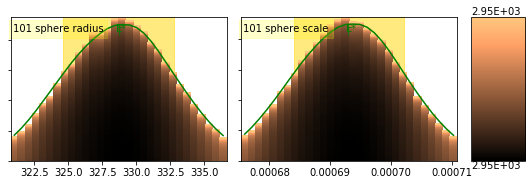

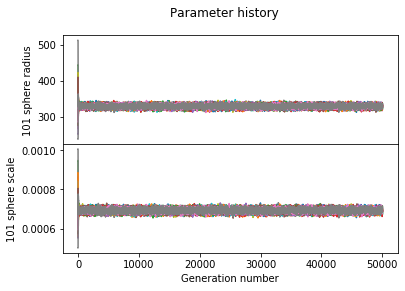

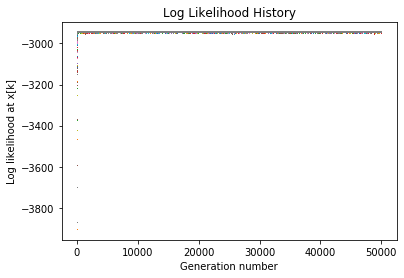

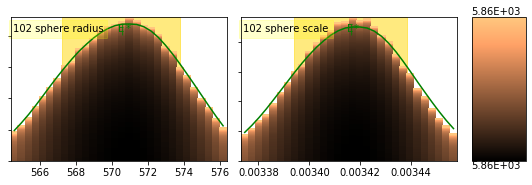

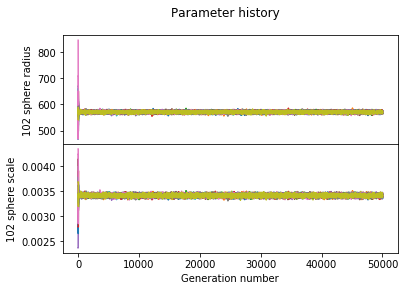

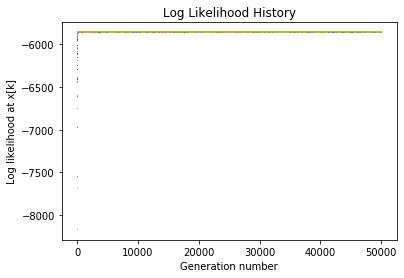

In [34]:
results = {}

kernel = load_model("guinier_porod+sphere")

run_keys = [101,102]

#run_keys = [key for key in run_keys if key in actual.keys() and key in usans_data.keys()]
for key in run_keys:
    
    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]
    
    vol = actual[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev[key]/100
    
    # initial parameter values
    
    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')
    
    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')
    
    B_scale_normal = bumps.bounds.BoundedNormal(mu=vol, sigma=vol_stdev, limits=(0, inf))
    B_scale = Parameter(vol, name=str(key) + ' sphere scale', bounds=B_scale_normal)
    
    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
    B_radius = Parameter(10000, limits=[0,inf], name=str(key) + ' sphere radius')
    B_radius_pd = Parameter(0.5, name = str(key) + ' sphere radius pd')
    B_radius_pd_n = Parameter(200, name = str(key) + ' sphere radius pd n')
    B_radius_pd_nsigma = Parameter(8, name = str(key) + ' sphere radius pd nsigma') 
    
    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius=B_radius,
        B_radius_pd_type='lognormal',
        B_radius_pd=B_radius_pd,
        B_radius_pd_n=B_radius_pd_n,
        B_radius_pd_nsigma=B_radius_pd_nsigma,
    )

    # setting parameter ranges as needed
    
#     sans_model.A_scale.range(min_scale*(1-vol), max_scale*(1-vol))
#     sans_model.A_rg.range(min_rg, max_rg)
#     sans_model.A_s.range(min(ps_s, ps_s_95[0]), max(ps_s, ps_s_95[1]))
#     sans_model.A_porod_exp.range(min(ps_porod_exp, ps_porod_exp_95[0]), max(ps_porod_exp, ps_porod_exp_95[1]))
    
    sans_model.B_radius.range(0,150000)
    #sans_model.B_scale.range(vol-vol_stdev, vol+vol_stdev)

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]

    problem=FitProblem(experiment)
    result=fit(problem, method='dream', samples=1e6, verbose=True)
    result.state.show(figfile='fitting_results/ps_sphere/CMW' + str(key) + '_ps_sphere')
    plt.close()

    results[key] = problem


101


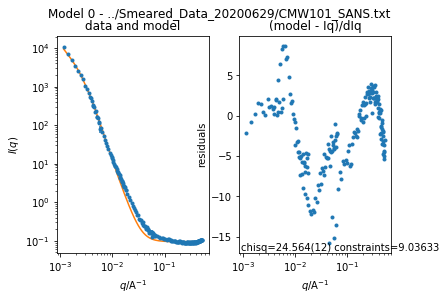

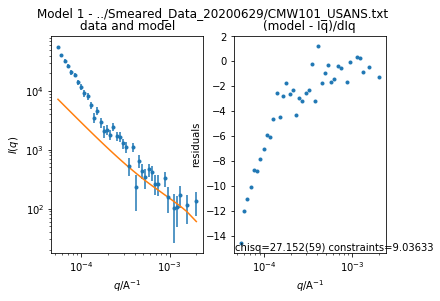

102


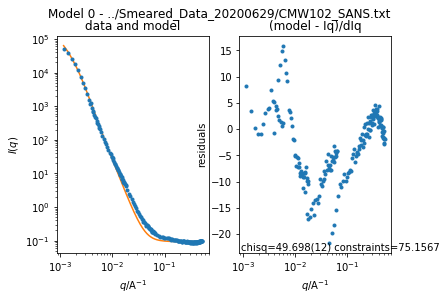

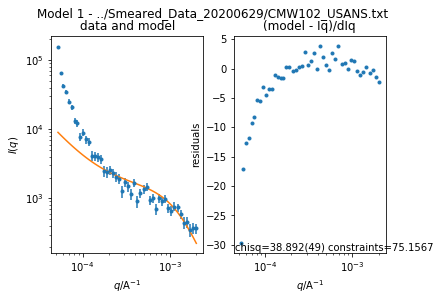

In [35]:
for key, problem in results.items():
    print(key)
    problem.plot()
    plt.show()
    plt.close()